# Bundle Adjustment SLAM in 2D

STUDENT VERSION.

Students: Please open a terminal and run `pip install -r requirements.txt` before proceeding.

In [1]:
# Import standard packages
# For vectorized operations and linear algebra
import numpy as np
# For plotting
import matplotlib.pyplot as plt
# For loading in the CSV data as a proper table (i.e., dataframe)
import pandas as pd

# Import the key packages for gtsam
# The top level package
import gtsam
# As implied, the plotting tools
import gtsam.utils.plot as gtsam_plot
# Convenience methods for landmarks (L) and states (X)
# These need to be reset if defined later
from gtsam.symbol_shorthand import L, X

Now we need to load in the data. Click the folder icon at left. This is your directory. Drag the `robot_history_{num}.csv` files into the panel that appears. You will have to repeat this if you restart the Google Colab session.

In [2]:
# Load in the data as a table

# You will come back to change this at the end
### TODO (Q4.b and Q4.g) ###
robot_gt_df = pd.read_csv('robot_history_5.csv') # this is GROUND TRUTH (gt)!
###

# Data is (time), (x, y, theta), (speed, dtheta), (measurements)
n_time_steps, n_params = robot_gt_df.shape
n_landmarks = (n_params - (1 + 3 + 2)) // 2

print(f"Data contains {n_time_steps} time steps and {n_landmarks} landmarks.\n")
robot_gt_df

Data contains 11 time steps and 12 landmarks.



,# time,x,y,theta,speed,dtheta,range_0,range_1,range_2,range_3,...,bearing_2,bearing_3,bearing_4,bearing_5,bearing_6,bearing_7,bearing_8,bearing_9,bearing_10,bearing_11
0,0.0,0.0,0.0,0.000000,3.0,0.000000,1.414214,1.414214,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.036243,NaN
1,1.0,3.0,0.0,0.000000,3.0,0.000000,4.123106,4.123106,2.236068,4.123106,...,26.565051,14.036243,NaN,NaN,NaN,NaN,NaN,63.434949,NaN,NaN
2,2.0,6.0,0.0,0.000000,3.0,0.000000,NaN,NaN,1.414214,1.414214,...,135.000000,45.000000,14.036243,NaN,NaN,NaN,75.963757,104.036243,NaN,NaN
3,3.0,9.0,0.0,0.000000,3.0,1.570796,NaN,NaN,4.123106,2.236068,...,165.963757,153.434949,45.000000,-18.434949,NaN,75.963757,116.565051,NaN,NaN,NaN
4,4.0,12.0,0.0,1.570796,2.5,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,63.434949,-180.000000,NaN,26.565051,NaN,NaN,NaN,NaN
5,5.0,12.0,2.5,1.570796,2.5,1.570796,NaN,NaN,NaN,NaN,...,NaN,NaN,126.869898,-180.000000,0.000000,53.130102,NaN,NaN,NaN,NaN
6,6.0,12.0,5.0,-3.141593,3.0,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,63.434949,NaN,-90.000000,26.565051,NaN,NaN,NaN,NaN
7,7.0,9.0,5.0,-3.141593,3.0,0.000000,NaN,NaN,NaN,4.472136,...,NaN,63.434949,104.036243,NaN,-161.565051,135.000000,26.565051,14.036243,NaN,NaN
8,8.0,6.0,5.0,-3.141593,3.0,0.000000,NaN,NaN,4.123106,4.123106,...,75.963757,104.036243,NaN,NaN,NaN,165.963757,135.000000,45.000000,NaN,NaN
9,9.0,3.0,5.0,-3.141593,3.0,0.000000,NaN,NaN,4.472136,NaN,...,116.565051,NaN,NaN,NaN,NaN,NaN,165.963757,153.434949,14.036243,-14.036243


## Adding noise

The data provided is ground truth. The code below adds the required noise. You can change these, but you should put everything back to the original settings when you submit

In [3]:
## Code to roll out the trajectory

def step_robot_pose(pose_curr: np.ndarray, speed: float, delta_theta: float):
    """
    Take the speed and turn to update the 2D pose.
    """
    # Unpack the pose
    x, y, theta = pose_curr

    # Update the position
    x += speed * np.cos(theta)
    y += speed * np.sin(theta)

    # Update the angle at the END of the step
    theta += delta_theta

    # Wrap the angle to [-pi, pi]
    theta = (theta + np.pi) % (2 * np.pi) - np.pi

    # Pack the pose back up
    return np.array([x, y, theta])

def rollout_robot_pose(pose_start: np.ndarray,
                       speeds: np.ndarray,
                       delta_thetas: np.ndarray,
                       ignore_last: bool = True):
    """
    Take the starting pose and step multiple times to get a roll out from the
    starting pose.
    """
    pose_list = [pose_start]
    pose_curr = pose_start.copy()

    for speed, delta_theta in zip(speeds, delta_thetas):
        pose_curr = step_robot_pose(pose_curr, speed, delta_theta)
        pose_list.append(pose_curr)

    if ignore_last:
        pose_list.pop()

    return np.array(pose_list)

In [4]:
# Create noise models

# For the submission use noise_factor = 1, but you may find it helpful to use
# noise_factor = 1e-3 for testing your code.
noise_factor = 1

# NUMPY VERSIONS
# Feel free to change the numbers, just be sure to change them back for the
# homework submission.
# We assume "pretty good starting"
PRIOR_NOISE_NUMPY = noise_factor * np.array([0.1, 0.1, np.deg2rad(1)])
# 0.3 units in x and y, and 20 degree error in angle, perhaps from wheel encoder
ODOMETRY_NOISE_NUMPY = noise_factor * np.array([0.3, 0.3, np.deg2rad(20)])
# We assume the LIDAR measurements are a lot cleaner
# 0.01 in x and y, and 0.01 degree error in angle
MEASUREMENT_NOISE_NUMPY =  noise_factor * np.array([0.01, np.deg2rad(0.01)])

# GTSAM versions

PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(noise_factor * PRIOR_NOISE_NUMPY)
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(noise_factor * ODOMETRY_NOISE_NUMPY)
MEASUREMENT_NOISE = gtsam.noiseModel.Diagonal.Sigmas(noise_factor * MEASUREMENT_NOISE_NUMPY)

In [5]:
# Make a dataframe but with the noisy data
robot_noisy_df = robot_gt_df.copy()

# The random seed is for sanity, to make sure you can run the notebook again
# and get the exact same plots.
np.random.seed(273)
robot_noisy_df["speed"] += np.random.normal(0, ODOMETRY_NOISE_NUMPY[0], n_time_steps)
robot_noisy_df["dtheta"] += np.random.normal(0, ODOMETRY_NOISE_NUMPY[-1], n_time_steps)

# again, we are using "near-perfect initialization" or "relative to initialization"
# So, no noise is added to the initial pose
inital_pose = robot_gt_df[["x", "y", "theta"]].iloc[0].to_numpy()
robot_noisy_df[["x", "y", "theta"]] = rollout_robot_pose(
    inital_pose, robot_noisy_df["speed"], robot_noisy_df["dtheta"])

# add noise to the measurements
# Loop through the landmarks for range and bearing
for l_ind in range(n_landmarks):
    robot_gt_df[f"range_{l_ind}"] += np.random.normal(0, MEASUREMENT_NOISE_NUMPY[0], n_time_steps)
    robot_gt_df[f"bearing_{l_ind}"] += np.random.normal(0, MEASUREMENT_NOISE_NUMPY[1], n_time_steps)

robot_noisy_df

,# time,x,y,theta,speed,dtheta,range_0,range_1,range_2,range_3,...,bearing_2,bearing_3,bearing_4,bearing_5,bearing_6,bearing_7,bearing_8,bearing_9,bearing_10,bearing_11
0,0.0,0.000000,0.000000,0.000000,3.254924,-0.070605,1.414214,1.414214,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.036243,NaN
1,1.0,3.254924,0.000000,-0.070605,3.008145,-0.210278,4.123106,4.123106,2.236068,4.123106,...,26.565051,14.036243,NaN,NaN,NaN,NaN,NaN,63.434949,NaN,NaN
2,2.0,6.255575,-0.212213,-0.280883,3.222176,0.330512,NaN,NaN,1.414214,1.414214,...,135.000000,45.000000,14.036243,NaN,NaN,NaN,75.963757,104.036243,NaN,NaN
3,3.0,9.351478,-1.105413,0.049630,3.310150,2.089231,NaN,NaN,4.123106,2.236068,...,165.963757,153.434949,45.000000,-18.434949,NaN,75.963757,116.565051,NaN,NaN,NaN
4,4.0,12.657552,-0.941200,2.138860,2.482692,-0.335601,NaN,NaN,NaN,NaN,...,NaN,NaN,63.434949,-180.000000,NaN,26.565051,NaN,NaN,NaN,NaN
5,5.0,11.321861,1.151571,1.803259,2.678351,1.677509,NaN,NaN,NaN,NaN,...,NaN,NaN,126.869898,-180.000000,0.000000,53.130102,NaN,NaN,NaN,NaN
6,6.0,10.704836,3.757880,-2.802417,3.001207,-0.221030,NaN,NaN,NaN,NaN,...,NaN,NaN,63.434949,NaN,-90.000000,26.565051,NaN,NaN,NaN,NaN
7,7.0,7.874610,2.759347,-3.023447,2.853366,0.082388,NaN,NaN,NaN,4.472136,...,NaN,63.434949,104.036243,NaN,-161.565051,135.000000,26.565051,14.036243,NaN,NaN
8,8.0,5.041135,2.423018,-2.941059,2.969787,-0.219678,NaN,NaN,4.123106,4.123106,...,75.963757,104.036243,NaN,NaN,NaN,165.963757,135.000000,45.000000,NaN,NaN
9,9.0,2.130861,1.831459,3.122448,2.694623,0.190524,NaN,NaN,4.472136,NaN,...,116.565051,NaN,NaN,NaN,NaN,NaN,165.963757,153.434949,14.036243,-14.036243


## (Q4.b-c) Building the factor graph

In [6]:
# Re-import here so that you can rerun this cell to debug without rerunning
# everything
from gtsam.symbol_shorthand import L, X

# Create an empty nonlinear factor graph
### TODO (Q4.b) ###
graph = gtsam.NonlinearFactorGraph()
###

Xs = [X(i) for i in range(n_time_steps)]
Ls = [L(i) for i in range(n_landmarks)]

# Add a prior factor at the origin to set the origin of the SLAM problem
### TODO (Q4.b) ###
# graph.add(...)
prior_factor = gtsam.PriorFactorPose2(Xs[0],gtsam.Pose2(0,0,0),PRIOR_NOISE)
graph.add(prior_factor)
###

# Loop through the noisy data (i.e., `robot_noisy_df`)
# In the loop,
#    get the relative motion with pose_{i} - pose_{i - 1}
#    the measurements are in the noisy data
# Don't forget the loop closure constraint
### TODO (Q4.c) ####
for j in range(n_landmarks):
    if not np.isnan(robot_noisy_df[f"bearing_{j}"].iloc[0]):
        bearing = gtsam.Rot2.fromDegrees(np.rad2deg(robot_noisy_df[f"bearing_{j}"].iloc[0]))
        f2 = gtsam.BearingRangeFactor2D(Xs[0], Ls[j], bearing, robot_noisy_df[f"range_{j}"].iloc[0], MEASUREMENT_NOISE)
        graph.add(f2)
        
for i in range(1,n_time_steps):
    x_c,y_c,theta_c = robot_noisy_df[["x", "y", "theta"]].iloc[i].to_numpy()
    x_p,y_p,theta_p = robot_noisy_df[["x", "y", "theta"]].iloc[i-1].to_numpy()
    f1 = gtsam.BetweenFactorPose2(Xs[i-1], Xs[i], gtsam.Pose2(x_c-x_p,y_c-y_p,theta_c-theta_p), ODOMETRY_NOISE)
    graph.add(f1)
    for j in range(n_landmarks):
        if not np.isnan(robot_noisy_df[f"bearing_{j}"].iloc[i]):
            bearing = gtsam.Rot2.fromDegrees(np.rad2deg(robot_noisy_df[f"bearing_{j}"].iloc[i]))
            f2 = gtsam.BearingRangeFactor2D(Xs[i], Ls[j], bearing, robot_noisy_df[f"range_{j}"].iloc[i], MEASUREMENT_NOISE)
            graph.add(f2)
        

f3 = gtsam.BetweenFactorPose2(Xs[1],Xs[7],gtsam.Pose2(0,5,np.deg2rad(180)), ODOMETRY_NOISE)
graph.add(f3)
###

# Print the factor graph to see all the nodes
### TODO (Q4.c) ####
print(graph)
###

NonlinearFactorGraph: size: 60

Factor 0: PriorFactor on x0
  prior mean:  (0, 0, 0)
  noise model: diagonal sigmas [0.1; 0.1; 0.0174532925];

Factor 1: BearingRangeFactor
Factor 1:   keys = { x0 l0 }
  noise model: diagonal sigmas [0.01; 0.000174532925];
ExpressionFactor with measurement: bearing : -3.05310855
range  1.41421356

Factor 2: BearingRangeFactor
Factor 2:   keys = { x0 l1 }
  noise model: diagonal sigmas [0.01; 0.000174532925];
ExpressionFactor with measurement: bearing : 3.05310855
range  1.41421356

Factor 3: BearingRangeFactor
Factor 3:   keys = { x0 l10 }
  noise model: diagonal sigmas [0.01; 0.000174532925];
ExpressionFactor with measurement: bearing : -2.77790675
range  4.12310563

Factor 4: BetweenFactor(x0,x1)
  measured:  (3.25492435, 0, -0.0706048005)
  noise model: diagonal sigmas [0.3; 0.3; 0.34906585];

Factor 5: BearingRangeFactor
Factor 5:   keys = { x1 l0 }
  noise model: diagonal sigmas [0.01; 0.000174532925];
ExpressionFactor with measurement: bearing : -

## (Q4.d) Initialize the optimization problem

In [7]:
# Set-up a values data structure for the initial estimate
### TODO (Q4.d) ###
initial_estimate = gtsam.Values()
###

# Set the initial poses from the noisy odometry alone
# Hint, you already have this in `robot_noisy_df`
### TODO (Q4.d) ###
for i in range(n_time_steps):
    x,y,theta = robot_noisy_df[["x", "y", "theta"]].iloc[i].to_numpy()
    initial_estimate.insert(Xs[i], gtsam.Pose2(x,y,theta))
###

# Sample random values for the initial landmark positions
# In reality, you would have to estimate these from odometry,
# but to not over-complicate the problem, just use noisy
# ground-truth.
# In reality, the initialization is very important for the
# graph optimization to converge to a good solution!!
l_init_vec = [
    (-1, -1),
    (-1, 1),
    (5, 1),
    (7, 1),
    (10, 1),
    (12, -1),
    (12, 6),
    (10, 4),
    (7, 4),
    (5, 4),
    (-1, 4),
    (-1, 6)
]

for l_ind, L in enumerate(Ls):
    l_hat = l_init_vec[l_ind]
    point_init = (np.random.normal(l_hat[0], ODOMETRY_NOISE_NUMPY[0]),
                  np.random.normal(l_hat[1], ODOMETRY_NOISE_NUMPY[0]))
    # Add the initial estimates of the landmarks
    ### TODO (Q4.d) ###
    initial_estimate.insert(L, gtsam.Point2(point_init[0],point_init[1]))
    ###

# Print the initial estimates to verify
### TODO (Q4.d) ###
print(initial_estimate)
###

Values with 23 values:
Value l0: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-1.04531412;
	-1.21481369
]

Value l1: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-1.00629039;
	1.17309668
]

Value l2: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	4.5809314;
	0.992908941
]

Value l3: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	6.58246277;
	0.865267077
]

Value l4: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	9.66434412;
	1.08988328
]

Value l5: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	11.5884324;
	-1.3857714
]

Value l6: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	12.4511261;
	5.92072691
]

Value l7: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	9.46084069;
	3.89537827
]

Value l8: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	7.25516174;
	4.41311515
]

Value l9: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	4.81397342;
	3.97336983
]

Value l10: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-1.36212978;
	3.67352319
]

Value l11: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-0.498201812;
	5.55854322

## (Q4.d) Plotting

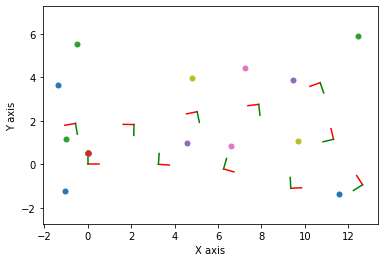

In [8]:
# Plot the initial poses and landmarks.
for x_ind, x_key in enumerate(Xs):
    gtsam_plot.plot_pose2(0, initial_estimate.atPose2(x_key), 0.5)

for l_ind, l_key in enumerate(Ls):
    gtsam_plot.plot_point2(0, initial_estimate.atPoint2(l_key), 0.5)


plt.axis('equal')
plt.show()

## (Q4.e) Graph Optimization

In [9]:
# We are going to optimize with the Levenberg-Marquardt solver.
# You can definitely consider other options (e.g., Gauss Newton).
# You may be interested in AA 222: Optimization for more about these
# methods. Levenberg-Marquardt has a number of configuration
# parameters, but we will use the defaults. For your projects, you
# might consider tweaking the parameters for tighter convergence.

lm_params = gtsam.LevenbergMarquardtParams()

# uncomment the two lines below
### TODO (Q4.e)  ###
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate,lm_params)
result = optimizer.optimize()
###

# Print the results
### TODO (Q4.e) ###
print(result)
###

Values with 23 values:
Value l0: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-1.27090455;
	-0.837744474
]

Value l1: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-1.27077597;
	-0.838217
]

Value l2: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	4.08705443;
	2.38020809
]

Value l3: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	5.57089239;
	3.78262106
]

Value l4: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	7.61448826;
	6.413714
]

Value l5: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	9.72272133;
	6.39569026
]

Value l6: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	5.20239875;
	11.2860205
]

Value l7: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	5.05483192;
	9.18237526
]

Value l8: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	2.27163994;
	7.35130009
]

Value l9: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	0.757367669;
	5.98184972
]

Value l10: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-3.2923384;
	1.33773815
]

Value l11: (Eigen::Matrix<double, -1, 1, 0, -1, 1>)
[
	-4.21896668;
	3.82501384
]



In [10]:
# To understand uncertainty, you need the marginal Gaussian distributions.
# gtsam makes this directly accessible with
# marginals = gtsam.Marginals(graph, result)
# The covariance matrices are in marginals. For example, the covariance
# matrix for X(1) (i.e., Xs[0]) is
# marginals.marginalCovariance(X(1))

# Check that you can print the marginal covariance matrices for both poses
# and landmarks
### TODO (Q4.e) ###
marginals = gtsam.Marginals(graph, result)
for x_ind, X in enumerate(Xs):
    print(x_ind," ",marginals.marginalCovariance(X))

for l_ind, L in enumerate(Ls):
    print(l_ind," ",marginals.marginalCovariance(L))
###

0   [[ 1.00000000e-02 -2.14204192e-12 -7.66647031e-13]
 [-2.14204192e-12  9.99999998e-03  9.88961370e-13]
 [-7.66647031e-13  9.88961370e-13  3.04617420e-04]]
1   [[ 0.01247284 -0.00255796 -0.00098485]
 [-0.00255796  0.01295469  0.00099905]
 [-0.00098485  0.00099905  0.00041584]]
2   [[ 0.01807134 -0.00850574 -0.00173239]
 [-0.00850574  0.01922005  0.00180055]
 [-0.00173239  0.00180055  0.00039687]]
3   [[ 0.01194784 -0.00780098 -0.00085057]
 [-0.00780098  0.04300117  0.00348926]
 [-0.00085057  0.00348926  0.00039354]]
4   [[ 0.07241433 -0.00686323  0.00482689]
 [-0.00686323  0.01083572 -0.00051643]
 [ 0.00482689 -0.00051643  0.00041017]]
5   [[0.06940913 0.00951287 0.00470647]
 [0.00951287 0.01169453 0.00077818]
 [0.00470647 0.00077818 0.00040187]]
6   [[ 0.01466813 -0.01696864  0.00130955]
 [-0.01696864  0.07569448 -0.00495293]
 [ 0.00130955 -0.00495293  0.0004101 ]]
7   [[ 0.0301283  -0.01994867  0.00275263]
 [-0.01994867  0.03037957 -0.00272338]
 [ 0.00275263 -0.00272338  0.00039355

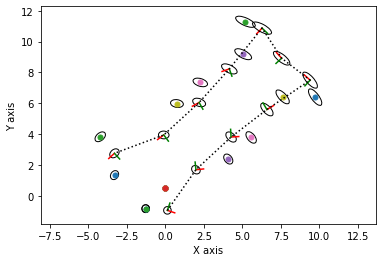

In [11]:
# Now plot the poses and landmarks _with_ covariance ellipses.
position_out = []

for x_ind, x_key in enumerate(Xs):
    m = marginals.marginalCovariance(x_key)
    pose_result_curr = result.atPose2(x_key)
    gtsam_plot.plot_pose2(0, pose_result_curr, 0.5, m)
    position_out.append(pose_result_curr.translation())

for l_ind, l_key in enumerate(Ls):
    m = marginals.marginalCovariance(l_key)
    gtsam_plot.plot_point2(0, result.atPoint2(l_key), 0.5, m)

# Connect the dots
position_out = np.array(position_out)
plt.plot(position_out[:, 0], position_out[:, 1], "k:")

plt.axis('equal')
plt.show()